<a href="https://colab.research.google.com/github/ssvakil/Machine-Learning-in-Python-Workshop/blob/master/Certified%20Adversarial%20Robustness%20via%20Randomized%20Smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and imports

In [1]:
!git clone https://github.com/sayakpaul/Denoised-Smoothing-TF
!cd Denoised-Smoothing-TF && tar xf models.tar.gz

Cloning into 'Denoised-Smoothing-TF'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 111 (delta 49), reused 60 (delta 21), pack-reused 0
Receiving objects: 100% (111/111), 13.00 MiB | 9.84 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [2]:
import sys
sys.path.append("Denoised-Smoothing-TF")

from models import resnet20

from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

With a TPU, you would need to have a GCS Bucket to serialize and load the `SavedModel` files. 

In [3]:
try: 
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: 
    strategy = tf.distribute.MirroredStrategy() 

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


## Load the CIFAR-10 dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

170498071/170498071 [==============================] - 4s 0us/step
Total training examples: 50000
Total test examples: 10000


## Define constants

In [5]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
EPOCHS = 90 
START_LR = 0.1 
AUTO = tf.data.AUTOTUNE

## Prepare data loaders

In [6]:
# Augmentation pipeline
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.RandomCrop(32, 32),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        )
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y), 
         num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Test dataset
test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y), 
         num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Compute the mean and the variance of the training data for normalization
data_augmentation.layers[0].adapt(x_train/255.) # Notice the scaling step

## Model utilities

In [7]:
def get_model(n_classes=10):
    n = 2
    depth = n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1

    # The input tensor
    inputs = layers.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs) # Normalize and augment

    # The Stem Convolution Group
    x = resnet20.stem(x)

    # The learner
    x = resnet20.learner(x, n_blocks)

    # The Classifier for 10 classes
    outputs = resnet20.classifier(x, 10)

    # Instantiate the Model
    model = tf.keras.Model(inputs, outputs)
    return model

In [8]:
# Serialize the initial model for better reproducibility
with strategy.scope():
    get_model().save("initial_model_resnet20")

## Model training

In [9]:
# LR Scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=3)

In [10]:
# Optimizer and loss function
optimizer = tf.keras.optimizers.SGD(learning_rate=START_LR, momentum=0.9)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

One can obtain the initial weights that I used from [here](https://github.com/sayakpaul/Denoised-Smoothing-TF/raw/main/models.tar.gz).

In [11]:
with strategy.scope():
    rn_model = tf.keras.models.load_model("initial_model_resnet20")
    rn_model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

history = rn_model.fit(train_ds,validation_data=test_ds,epochs=EPOCHS,callbacks=[reduce_lr])

Epoch 1/90
391/391 [==============================] - 46s 68ms/step - loss: 2.3765 - accuracy: 0.4353 - val_loss: 2.1574 - val_accuracy: 0.4687 - lr: 0.1000
Epoch 2/90
391/391 [==============================] - 24s 62ms/step - loss: 1.7953 - accuracy: 0.5945 - val_loss: 2.1714 - val_accuracy: 0.4506 - lr: 0.1000
Epoch 3/90
391/391 [==============================] - 24s 62ms/step - loss: 1.5572 - accuracy: 0.6569 - val_loss: 1.7020 - val_accuracy: 0.5859 - lr: 0.1000
Epoch 4/90
391/391 [==============================] - 24s 61ms/step - loss: 1.4309 - accuracy: 0.6966 - val_loss: 1.4798 - val_accuracy: 0.6742 - lr: 0.1000
Epoch 5/90
391/391 [==============================] - 24s 62ms/step - loss: 1.3735 - accuracy: 0.7188 - val_loss: 1.5881 - val_accuracy: 0.6367 - lr: 0.1000
Epoch 6/90
391/391 [==============================] - 24s 62ms/step - loss: 1.3367 - accuracy: 0.7345 - val_loss: 1.6937 - val_accuracy: 0.6006 - lr: 0.1000
Epoch 7/90
391/391 [==============================] - 25s 

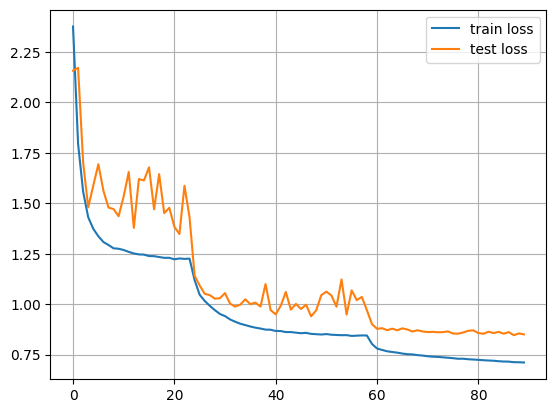

In [12]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="test loss")
plt.grid()
plt.legend()
plt.show()

rn_model.save("resnet20_classifier")

In [13]:
with strategy.scope():
    _, train_acc = rn_model.evaluate(train_ds, verbose=0)
    _, test_acc = rn_model.evaluate(test_ds, verbose=0)

print("Train accuracy: {:.2f}%".format(train_acc * 100))
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Train accuracy: 97.96%
Test accuracy: 90.17%
